In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import multiprocessing
from multiprocessing import Pool
import socket
import sys
import time
import math
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)

#from test import plot_channel as plt_channel

External libs path: 
/home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [3]:
dataset_dir = '/data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split'
temp_path = os.path.join(dataset_dir, 'data')
os.listdir(temp_path)[:10]

['312072.npz',
 '313603.npz',
 '200706.npz',
 '346973.npz',
 '338627.npz',
 '321932.npz',
 '269388.npz',
 '215108.npz',
 '269114.npz',
 '307285.npz']

In [12]:
cell_id = '269114'
temp_path = os.path.join(dataset_dir, 'data', cell_id+'.npz')
temp_cell = np.load(temp_path)
temp_img = temp_cell['img'].astype(np.float32)
temp_mask = temp_cell['mask']

max_val = np.max(temp_img, axis=(0,1))
temp_img = temp_img /max_val

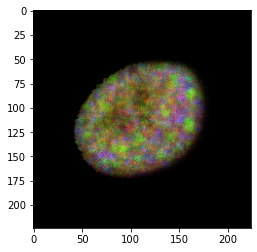

In [13]:
plt.imshow(temp_img[:,:,10:13],
           #cmap=getattr(plt.cm, 'Blues'),
           #vmin=vmin, vmax=vmax,
           aspect='equal'
          )
plt.grid(False)

In [61]:
@tf.function
def zoom_image(tensor_img, mode):

    def get_min_space(x):
        t_x = tf.cast(tf.math.not_equal(tf.math.reduce_sum(x, axis=(1,2)), 0), dtype=tf.float32)
        t_x_low = tf.math.argmax(t_x)
        t_x_top = tf.math.argmax(tf.reverse(t_x, axis=[0]))
        t_x_min = tf.math.minimum(t_x_low, t_x_top)
        t_y = tf.cast(tf.math.not_equal(tf.math.reduce_sum(x, axis=(0,2)), 0), dtype=tf.float32)
        t_y_low = tf.math.argmax(t_y)
        t_y_top = tf.math.argmax(tf.reverse(t_y, axis=[0]))
        t_y_min = tf.math.minimum(t_y_low, t_y_top)

        return tf.cast(tf.math.minimum(t_x_min, t_y_min), dtype=tf.float32)

    # get min space between the cell border and the image border
    min_space = get_min_space(tensor_img)
    # get image size
    img_size = tensor_img.shape[1]

    # Get the fraction of the origin image to crop without losing cell information
    img_size = tf.cast(img_size, dtype=tf.float32)
    frac2crop = 1 - 2 * (min_space / img_size)
    #print('Cell fraction of image: ', frac2crop)

    # Get image with the cell at its maximum size
    # Warning! function tf.image.central_crop requires frac2crop to be a fraction between 0 and 1!
    # However, this is a tf graph function, which means that all calculations here returns a tensor.
    # Therefore, you must change the origina library image_ops_impl.py for one from github which
    # supports a tensor as input:
    # wget https://raw.githubusercontent.com/tensorflow/tensorflow/b7a7f8d178254d1361d34dfc40a58b8dce48b9d7/tensorflow/python/ops/image_ops_impl.py
    # https://github.com/tensorflow/tensorflow/pull/45613/files
    tensor_img = tf.image.central_crop(tensor_img, frac2crop)
    #print('Size after cropping: ', tensor_img.shape)

    if mode == 'random_uniform':
        # Select uniformly random the cell size (between 40% and 100% of the image)
        cell_img_frac = tf.random.uniform(shape=[1], minval=0.4, maxval=1, dtype=tf.float32)
    elif mode == 'equal':
        cell_img_frac = tf.cast(1, dtype=tf.float32)
    #print('Target cell img fraction: ', cell_img_frac)

    # Create temp image with cell size specified by cell_img_frac (random)
    img_size = tf.cast(img_size, dtype=tf.float32)
    temp_size = tf.cast(cell_img_frac * img_size, dtype=tf.int32)
    temp_size = tf.repeat(temp_size,2)
    tensor_img = tf.image.resize(tensor_img,
                                 size=temp_size,
                                 #method=tf.image.ResizeMethod.BILINEAR,
                                 #method=tf.image.ResizeMethod.LANCZOS5,
                                 method='nearest',
                                 preserve_aspect_ratio=False,
                                 antialias=False)
    #print(tensor_img.shape)

    # Resize image to original size
    img_size = tf.cast(img_size, dtype=tf.int32)
    tensor_img = tf.image.resize_with_crop_or_pad(image=tensor_img,
                                                  target_height=img_size,
                                                  target_width=img_size)

    return tensor_img

temp_tensor = tf.constant(temp_img)
temp_tensor = tf.cast(temp_tensor, dtype=tf.float32)

temp_mask_tensor = tf.constant(temp_mask)
temp_mask_tensor = tf.cast(temp_mask_tensor, dtype=tf.float32)
temp_mask_tensor = tf.expand_dims(temp_mask_tensor, axis=-1)

tensor_img = zoom_image(temp_tensor, 'equal')
tensor_mask = zoom_image(temp_mask_tensor, 'equal')

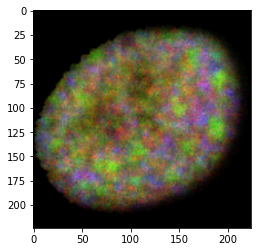

In [50]:
plt.imshow(tensor_img.numpy()[:,:,10:13],
           #cmap=getattr(plt.cm, 'Blues'),
           #vmin=vmin, vmax=vmax,
           aspect='equal'
          )
plt.grid(False)

(array([17034.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 33142.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

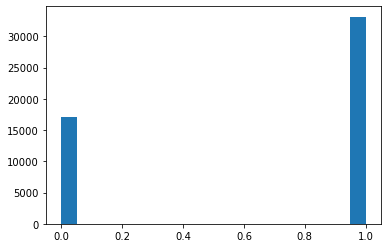

In [63]:
temp_data = tensor_mask.numpy()[:,:,0].reshape(-1)
plt.hist(temp_data, bins=20)

In [64]:
np.unique(temp_data)

array([0., 1.], dtype=float32)

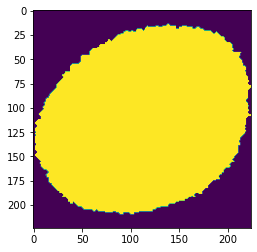

In [65]:
temp_mask = tensor_mask.numpy()[:,:,0]

plt.imshow(temp_mask,
           #cmap=getattr(plt.cm, 'Blues'),
           #vmin=vmin, vmax=vmax,
           aspect='equal'
          )
plt.grid(False)

(array([16398.,    97.,    74.,    67.,    74.,    66.,    76.,    62.,
           52.,    68.,    46.,    92.,    55.,    67.,    68.,    56.,
           61.,   101.,    77., 32519.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

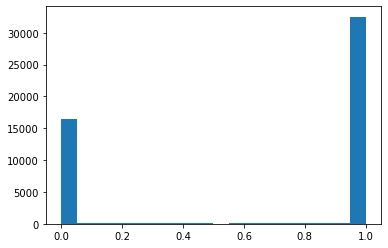

In [46]:
temp_data = tensor_mask.numpy()[:,:,0].reshape(-1)
plt.hist(temp_data, bins=20)

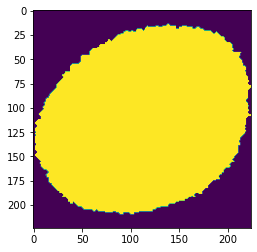

In [48]:
temp_mask = np.zeros(temp_mask.shape)
temp_mask[tensor_mask.numpy()[:,:,0] > 0.5] = 1

plt.imshow(temp_mask,
           #cmap=getattr(plt.cm, 'Blues'),
           #vmin=vmin, vmax=vmax,
           aspect='equal'
          )
plt.grid(False)